## This notebook is based on this [notebook from Kaggle](https://www.kaggle.com/code/pankajj/fashion-mnist-with-pytorch-93-accuracy)

# **Importing Important Libraries**

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_formats = ['svg']

### If the GPU is available use it for the computation otherwise use the CPU.

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Using FashionMNIST class from torchvision module.


*   It will download the dataset first time.




In [27]:
"""
train_set = torchvision.datasets.FashionMNIST("./fashion_mnist", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./fashion_mnist", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))  
"""                                               

'\ntrain_set = torchvision.datasets.FashionMNIST("./fashion_mnist", download=True, transform=\n                                                transforms.Compose([transforms.ToTensor()]))\ntest_set = torchvision.datasets.FashionMNIST("./fashion_mnist", download=True, train=False, transform=\n                                               transforms.Compose([transforms.ToTensor()]))  \n'

In [28]:
train_set = torchvision.datasets.FashionMNIST("./fashion_mnist/", transform=
                                                transforms.Compose([transforms.ToTensor()]))
test_set = torchvision.datasets.FashionMNIST("./fashion_mnist/", train=False, transform=
                                               transforms.Compose([transforms.ToTensor()])) 

In [29]:
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [30]:
len(train_set), len(test_set)

(60000, 10000)

### We have 10 types of clothes in FashionMNIST dataset.


> Making a method that return the name of class for the label number.
ex. if the label is 5, we return Sandal.



In [31]:
text_labels = ("T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",  "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot")

### Playing with data and displaying some images using matplotlib imshow() method.





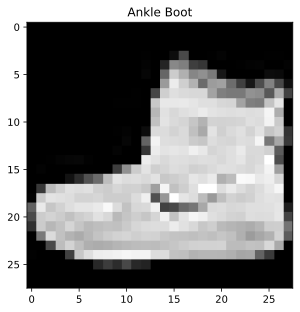

In [32]:
image, label = next(iter(train_set))
plt.imshow(image.squeeze(), cmap="gray")
plt.title(text_labels[label]);

In [33]:
demo_loader = torch.utils.data.DataLoader(train_set, batch_size=10)

batch = next(iter(demo_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([10, 1, 28, 28]) torch.Size([10])


labels:  Ankle Boot, T-shirt/Top, T-shirt/Top, Dress, T-shirt/Top, Pullover, Sneaker, Pullover, Sandal, Sandal, 

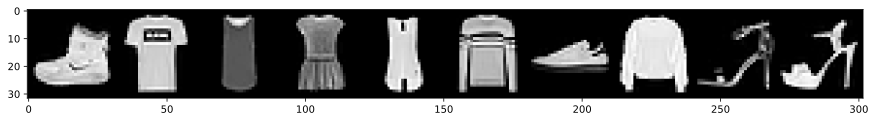

In [34]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("labels: ", end=" ")
for i, label in enumerate(labels):
    print(text_labels[label], end=", ")

## Building a CNN 

![](https://saturncloud.io/images/blog/a-cnn-sequence-to-classify-handwritten-digits.webp)

*   Make a model class (FashionCNN in our case)
    * It inherit nn.Module class that is a super class for all the neural networks in Pytorch.
* Our Neural Net has following layers:
    * Two Sequential layers each consists of following layers-
        * Convolution layer that has kernel size of 3 * 3, padding = 1 (zero_padding) in 1st layer and padding = 0 in second one. Stride of 1 in both layer.
        * Batch Normalization layer.
        * Acitvation function: ReLU.
        * Max Pooling layer with kernel size of 2 * 2 and stride 2.
     * Flatten out the output for dense layer(a.k.a. fully connected layer).
     * 3 Fully connected layer  with different in/out features.
     * 1 Dropout layer that has class probability p = 0.25.
  
     * All the functionaltiy is given in forward method that defines the forward pass of CNN.
     * Our input image is changing in a following way:
        * First Convulation layer : input: 28 \* 28 \* 3, output: 28 \* 28 \* 32
        * First Max Pooling layer : input: 28 \* 28 \* 32, output: 14 \* 14 \* 32
        * Second Conv layer : input : 14 \* 14 \* 32, output: 12 \* 12 \* 64
        * Second Max Pooling layer : 12 \* 12 \* 64, output:  6 \* 6 \* 64
    * Final fully connected layer has 10 output features for 10 types of clothes.

> Lets implementing the network...





In [35]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.layer3 = nn.Sequential(
            nn.Linear(in_features=64*6*6, out_features=600),
            nn.BatchNorm1d(600),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.layer4 = nn.Sequential(
            nn.Linear(in_features=600, out_features=120),
            nn.BatchNorm1d(120),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.fc3(out)
        
        return out


### Making a model of our CNN class

*   Creating a object(model in the code)
*   Transfering it into GPU if available.
*  Defining a Loss function. we're using CrossEntropyLoss() here.
*  Using Adam algorithm for optimization purpose.



In [39]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=3, gamma=0.5, verbose=True)
print(model)

Adjusting learning rate of group 0 to 1.0000e-03.
FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=2304, out_features=600, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=600, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


## Training a network and Testing it on test dataset

In [40]:
from time import time

def train_nn(num_epochs):
    # Lists for visualization of loss and accuracy 
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    for epoch in range(num_epochs):
        start_time = time()
        for images, labels in train_loader:
            # Transfering images and labels to GPU if available
            model.train()
            images, labels = images.to(device), labels.to(device)
    
            train = Variable(images.view(batch_size, 1, 28, 28))
            labels = Variable(labels)
        
            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels)
        
            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()
        
            #Propagating the error backward
            loss.backward()
        
            # Optimizing the parameters
            optimizer.step()
        
            train_loss.append(loss.data.numpy())
        
            predictions = torch.max(outputs, 1)[1].to(device)
        
            #print(predictions)
            #print(labels)
            train_accuracy.append((predictions == labels).float().mean())

        scheduler.step()

        # Testing the model
    
        model.eval()
        
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # labels_list.append(labels)
            
            test = Variable(images.view(100, 1, 28, 28))
            
            outputs = model(test)
            
            predictions = torch.max(outputs, 1)[1].to(device)
        
            test_accuracy.append((predictions == labels).float().mean())
        
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(train_set) // batch_size :])))
        print("  train accruracy (in-iteration): \t{:.2%}".format(
            np.mean(train_accuracy[-len(train_set) // batch_size :])))
        print("  test accuracy: \t\t\t{:.2f} %".format(
            np.mean(test_accuracy[-len(test_set) // batch_size :]) * 100))

In [41]:
train_nn(10)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1 of 10 took 80.705s
  training loss (in-iteration): 	0.524848
  train accruracy (in-iteration): 	80.39%
  test accuracy: 			86.59 %
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2 of 10 took 77.068s
  training loss (in-iteration): 	0.312678
  train accruracy (in-iteration): 	88.52%
  test accuracy: 			88.44 %
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 3 of 10 took 79.226s
  training loss (in-iteration): 	0.257260
  train accruracy (in-iteration): 	90.62%
  test accuracy: 			89.48 %
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 4 of 10 took 78.640s
  training loss (in-iteration): 	0.208871
  train accruracy (in-iteration): 	92.30%
  test accuracy: 			90.57 %
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 5 of 10 took 82.305s
  training loss (in-iteration): 	0.188940
  train accruracy (in-iteration): 	93.09%
  test accuracy: 			90.79 %
Adjusting learning rate of group 0 to 2.5000e-04.
Epoch

### Data augmentation

In [50]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
scheduler = StepLR(optimizer, step_size=4, gamma=0.5, verbose=True)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

train_set = torchvision.datasets.FashionMNIST("./fashion_mnist/", train=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

Adjusting learning rate of group 0 to 1.0000e-03.


In [51]:
train_nn(15)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1 of 15 took 112.735s
  training loss (in-iteration): 	0.693281
  train accruracy (in-iteration): 	73.61%
  test accuracy: 			81.25 %
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 2 of 15 took 91.830s
  training loss (in-iteration): 	0.470194
  train accruracy (in-iteration): 	82.04%
  test accuracy: 			84.63 %
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 3 of 15 took 105.945s
  training loss (in-iteration): 	0.407482
  train accruracy (in-iteration): 	84.61%
  test accuracy: 			86.66 %
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 4 of 15 took 114.632s
  training loss (in-iteration): 	0.362701
  train accruracy (in-iteration): 	86.40%
  test accuracy: 			87.59 %
Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 5 of 15 took 97.785s
  training loss (in-iteration): 	0.335083
  train accruracy (in-iteration): 	87.45%
  test accuracy: 			87.99 %
Adjusting learning rate of group 0 to 5.0000e-04.
Ep